In [1]:
import numpy as np
import os
from scipy.stats import norm
import math
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pandas.tseries.offsets import DateOffset
from dateutil.relativedelta import relativedelta
from scipy.optimize import fsolve, root
import datetime
import statsmodels.api as sm

## fixed income functions with option expiry

In [2]:
# curve data
os.chdir('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/data 13 11/')
EUSA = pd.read_excel('EUSA_data.xlsx')

# change dataframe layout
index = EUSA['Dates'].copy()
EUSA = pd.melt(EUSA.reset_index(),
               id_vars=['Dates'],
               value_vars=['6M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '12Y', '15Y', '20Y', '25Y', '30Y'],
               var_name='Maturity', value_name='Spot rate').set_index(['Dates'])
EUSA.name = 'EUSA'

# convert strings to float
def maturity_convert(Maturity):
    if Maturity[-1] == 'M':
        MaturityInYear = float(Maturity[:-1]) / 12  # if 6M -> 6/12
    else:
        MaturityInYear = float(Maturity[:-1])       # if xY -> float(x)
    return MaturityInYear

EUSA['Maturity (years)'] = EUSA['Maturity'].apply(lambda x: maturity_convert(x))

# change % to decimal
EUSA['Spot rate (decimal)'] = EUSA['Spot rate'].apply(lambda x: x / 100)

# cubic spline interpolation
def cubspline_curve(date, T, df_curve):
    S = interp1d(df_curve['Maturity (years)'][str(date)], 
                 df_curve['Spot rate (decimal)'][str(date)], 
                 kind='cubic', 
                 fill_value='extrapolate')
    return S(T)

###### #######
tau_floating = 0.5  # EUSA swaps are semi-annual
tau_fixed = 1       # fixed rates paid annually
date = datetime.date(2023,9,18)
###### #######

def disc_factor(date, T, curve = EUSA):
    
    rate = np.log(1 + cubspline_curve(date, T, curve))

    return np.exp(-rate * T)    # curve is cont. comp.

def forw_rate(date, T, tau, curve = EUSA):

    P_0_T = disc_factor(date, T, curve)
    P_0_T_tau = disc_factor(date, T+tau, curve)

    return 1 / tau * (P_0_T / P_0_T_tau - 1)

def payment_schedule(date, expiry, tenor, tau):
    unadj_dates = []
    adj_dates = []

    t_0 = pd.Timestamp(date).date()
    t_m = (t_0 + DateOffset(months=(expiry * 12)) + pd.tseries.offsets.BusinessDay(0)).date()
    t_n = (t_m + DateOffset(months=(tenor * 12))).date()    #unadjusted for business days
    t_m_copy = t_m

    delta_months = relativedelta(months=+(tau * 12))

    while t_m_copy < t_n:
        unadj_dates.append(t_m_copy)
        t_m_copy = t_m_copy + delta_months

    unadj_dates.append(t_m_copy)

    for date in unadj_dates:
        adj_dates.append((date + pd.tseries.offsets.BusinessDay(0)).date())
    
    return adj_dates

def coverage(date, expiry, tenor, tau):
    coverage = []
    dates = []

    adj_dates = payment_schedule(date, expiry, tenor, tau)
    t_0 = pd.Timestamp(date).date()
    dates_roll = expiry + tau

    for i in range(1, len(adj_dates)):
        coverage.append(1 / 360 * (
            360 * (adj_dates[i].year - adj_dates[i - 1].year)
            + 30 * (adj_dates[i].month - adj_dates[i - 1].month)
            + min(30, adj_dates[i].day) 
            - min(30, adj_dates[i - 1].day)
            )
        )
        dates.append(dates_roll)
        dates_roll = dates_roll + coverage[i - 1]

    # coverage[0] = coverage
    # coverage[1] = tidspunkt for betaling
    return coverage, dates

def swap_rate(date, expiry, tenor, tau_floating, tau_fixed, curve = EUSA):
    floating_leg = 0
    fixed_leg = 0

    floating_coverage, floating_dates = coverage(date, expiry, tenor, tau_floating)
    fixed_coverage, fixed_dates = coverage(date, expiry, tenor, tau_fixed)

    for i in range(len(floating_dates)):
        floating_leg = floating_leg + disc_factor(date, floating_dates[i], curve) * floating_coverage[i] * forw_rate(date, floating_dates[i] - floating_coverage[i], floating_coverage[i],  curve)

    for i in range(len(fixed_dates)):
        fixed_leg = fixed_leg + disc_factor(date, fixed_dates[i]) * fixed_coverage[i]

    return floating_leg / fixed_leg

def annuity_func(date, expiry, tenor, tau, curve = EUSA):
    ann = 0
    cov, dates = coverage(date, expiry, tenor, tau)
    for i in range(len(dates)):
        ann = ann + disc_factor(date, dates[i], curve) * cov[i]
    return ann

def bachelier(F, K, sigma_normal, date, expiry, tenor, tau, t = 0):
    d = (F - K) / (sigma_normal * np.sqrt(expiry - t))
    return annuity_func(date, expiry, tenor, tau) * ((F - K) * norm.cdf(d) + sigma_normal * np.sqrt(expiry - t) * norm.pdf(d))

tau_floating = 0.5
tau_fixed = 1 

## payer swaption closed form

In [3]:
def trap_integration(xmin, xmax, N):
    # Computes integration points and weights for trapezoid scheme
    # integrates from xmin to xmax with N integration points
    uv = np.linspace(xmin, xmax, N)
    wgtv = np.ones(N)
    wgtv[[0, N - 1]] = 1 / 2
    wgtv = wgtv * (xmax - xmin) / (N - 1)
    return uv, wgtv

def char_func(u, T, theta, eta, z_0, lambd, b):
    v = 1/2 * (lambd * b)**2 * u * (u - 1)

    gamma = np.sqrt(theta**2 - 2 * eta**2 * v)
    A = 1 / eta**2 * theta * z_0 * (2 * np.log(2 * gamma / (theta + gamma - np.exp(-gamma * T)*(theta - gamma))) + (theta - gamma) * T)
    B = 2 * v * (1 - np.exp(-gamma * T)) / ((theta + gamma) * (1 - np.exp(-gamma * T)) + 2 * gamma * np.exp(-gamma * T))
    return np.exp(A + B * z_0)

def payer_price_SV(S, K, L, theta, eta, lambd, b, z_0, date, expiry, tenor):
    xmin = 0
    xmax = 2000
    int_points = 10000
    [u, wgt] = trap_integration(xmin, xmax, int_points)
    
    S_prime = b * S + (1 - b) * L
    K_prime = b * K + (1 - b) * L

    integrand = np.real((np.exp(-(1/2 + 1j * u) * np.log(K_prime / S_prime)) * char_func(1/2 + 1j * u, expiry, theta, eta, z_0, lambd, b)) / (u**2 + 1/4))
    integral = sum(wgt * integrand)

    annuity = annuity_func(date, expiry, tenor, tau_floating_leg, EUSA)

    return annuity / b * (S_prime - K_prime / np.pi * integral)

tau_floating_leg = 0.5
date = datetime.date(2023, 9, 18)
b = 0.5
lambd = 0.8
eta = 0.5
rho = 0.5
theta = 0.5
T = 0.5
z_0 = 1
S = 0.05
K = 0.04
expiry = 2
tenor = 10
L = S

payer_price_SV(S, K, L, theta, eta, lambd, b, z_0, date, expiry, tenor)

0.20887807737425323

## Load data

In [4]:
swaption_data = pd.read_excel('swaption_cube.xlsx')
number_of_grids = len(pd.ExcelFile('swaption_cube.xlsx').sheet_names) / 2
xl_names = pd.ExcelFile('swaption_cube.xlsx').sheet_names[:int(number_of_grids)]

df_swaption_iv = []

for i in range(int(number_of_grids)):
    grid_i = pd.read_excel('swaption_cube.xlsx', sheet_name=(i), index_col = 0)
    grid_i.name = grid_i.index.name
    df_swaption_iv.append(grid_i)

# the swaption_iv holds the swaption grid for different strikes
# its dimensions are (m, n, #number of strikes)
# the calibration will be done for each (m, n)-pair with weights assigned for each strike
# access the grids by swaption_iv[i]
# access grid-points by swaption_iv[i].iloc[j,k]

In [5]:
swaption_data = pd.read_excel('swaption_cube.xlsx')
number_of_grids = len(pd.ExcelFile('swaption_cube.xlsx').sheet_names) / 2
xl_names = pd.ExcelFile('swaption_cube.xlsx').sheet_names[int(number_of_grids):]

df_swaption_strikes = []

for i in range(int(number_of_grids),2*int(number_of_grids)):
    grid_i = pd.read_excel('swaption_cube.xlsx', sheet_name=(i), index_col = 0)
    grid_i.name = grid_i.index.name
    df_swaption_strikes.append(grid_i)

# the swaption_iv holds the swaption grid for different strikes
# its dimensions are (m, n, #number of strikes)
# the calibration will be done for each (m, n)-pair with weights assigned for each strike
# access the grids by swaption_iv[i]
# access grid-points by swaption_iv[i].iloc[j,k]

## Set up lists with strikes, prices, swap rates

In [ ]:
swaption_expiry = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])
swaption_tenor = np.array([1, 2, 3, 4, 5, 7, 10, 12, 15, 20, 25, 30])

df_strike = []
df_swap_rate = []
df_price = []

for i in range(len(df_swaption_iv)): # grid loop
    [M,N] = df_swaption_iv[i].shape

    df_strike_i = df_swaption_iv[i].copy()
    df_swap_rate_i = df_swaption_iv[i].copy()
    df_price_i = df_swaption_iv[i].copy()

    for m in range(M): # expiry loop
        T = swaption_expiry[m]      

        for n in range(N): # tenor loop
            tenor = swaption_tenor[n]
            moneyness = float(df_swaption_strikes[i].name) / 10000  # convert from bps. to decimal

            K = df_swaption_strikes[i].iloc[m,n] / 100
            S = K - moneyness

            normal_vol = df_swaption_iv[i].iloc[m,n] / 10000   # convert from bps. to decimal
            
            df_strike_i.iloc[m,n] = K
            df_swap_rate_i.iloc[m,n] = S
            df_price_i.iloc[m,n] = bachelier(S, K, normal_vol, datetime.date(2023, 9, 18), T, tenor, tau_floating, t = 0)  # bachelier price (since data uses normal vols)
    
    df_strike.append(pd.DataFrame(df_strike_i))
    df_swap_rate.append(pd.DataFrame(df_swap_rate_i))
    df_price.append(pd.DataFrame(df_price_i))

df_strike, df_swap_rate, df_price

### 10 year tenor swaption strip (find $\theta$)

In [7]:
strike_strips = []
swaprate_strips = []
price_strips = []

for i in range(len(df_strike)):
    strike_strips.append(df_strike[i].loc[:,"10Yr"])
    swaprate_strips.append(df_swap_rate[i].loc[:,"10Yr"])
    price_strips.append(df_price[i].loc[:,"10Yr"])

In [ ]:
expiry = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])

# moneyness         +200  +100  +50  +25   ATM  -25   -50  -100  -200
weights = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

# # moneyness         +200  +100  +50  +25   ATM  -25   -50  -100  -200
# weights = np.array([0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0])

lambd_calibrated = price_strips[0].copy()
b_calibrated = price_strips[0].copy()
eta_calibrated = price_strips[0].copy()
model_prices = price_strips[0].copy()
date = datetime.date(2023, 9, 18)

z_0 = 1
tenor = 10

thetas = np.array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
colors = ['b', 'r', 'g', 'm', 'c', 'y', 'lawngreen', 'grey']

etas_calibrated = []
M = len(expiry)


for i in range(len(thetas)): # len(thetas)
    theta = thetas[i]

    for m in range(M):  # calibrate swaption m
        T = expiry[m]
        print("Expiry = ", T)

        strikes_i = []
        swap_rate_i = []
        market_price_i = []

        for i in range(len(strike_strips)): # strikes loop

            strikes_i.append(strike_strips[i].iloc[m])
            swap_rate_i.append(swaprate_strips[i].iloc[m])
            market_price_i.append(price_strips[i].iloc[m])

        for p in range(1):  # calibrate (m,n)-swaption
            strikes = np.array(strikes_i)
            obs_prices = np.array(market_price_i)
            obs_swap_rates = np.array(swap_rate_i)

            bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf))

            init_lambd = 0.5
            init_b = 0.50
            init_eta = 0.50
            initguess = [init_lambd, init_b, init_eta]


            def Err(x):
                lambd, b, eta = x

                price_hat = []

                for i in range(len(strike_strips)):
                    
                    price_hat.append(payer_price_SV(obs_swap_rates[i], strikes[i], obs_swap_rates[i], theta, eta, lambd, b, z_0, date, T, tenor))

                price_hat = np.array(price_hat)
                err = np.sum(weights * (price_hat - obs_prices)**2)

                return err

        res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-14)
        lambd, b, eta = res.x

        lambd_calibrated[m] = lambd
        b_calibrated[m] = b
        eta_calibrated[m] = eta

        print('\n', "observed ATM price = ", market_price_i[4]) # market price
        print('\n', "calibrated ATM price = ", payer_price_SV(obs_swap_rates[4], strikes[4], obs_swap_rates[4], theta, eta, lambd, b, z_0, date, T, tenor))
        print('\n', 'calibrated lambda', lambd)
        print('\n', 'calibrated b', b)
        print('\n', 'calibrated eta', eta)

    etas_calibrated.append(list(eta_calibrated))

fig, ax = plt.subplots(figsize=(10,6))

# ax.set_yticks(np.arange(0,3.5, 0.5))
# ax.set_ylim(0,3)
ax.set_xlim(0, 18)
ax.set_xlabel('Option expiry')
ax.set_title('$\\eta(m)$')
for i in range(len(etas_calibrated)):
    plt.plot(eta_calibrated.index, etas_calibrated[i], label = '$\\theta$ = '+str(thetas[i]), color = colors[i])
plt.legend(frameon=False, loc = 'upper left', fontsize=11)
fig.tight_layout()

plt.show()

## calibrate to ATM only

In [9]:
strike_strips = []
swaprate_strips = []
price_strips = []

for i in range(len(df_strike)):
    strike_strips.append(df_strike[i].loc[:,"10Yr"])
    swaprate_strips.append(df_swap_rate[i].loc[:,"10Yr"])
    price_strips.append(df_price[i].loc[:,"10Yr"])

Expiry =  0.08333333333333333

 observed ATM price =  0.008110799006955988

 calibrated ATM price =  0.008110798849808528

 calibrated lambda 0.25807526743771636

 calibrated b 0.49988423645380975

 calibrated eta 0.49967580541016354
Expiry =  0.25

 observed ATM price =  0.01502835328222943

 calibrated ATM price =  0.015028353013977872

 calibrated lambda 0.2796577207865679

 calibrated b 0.49990793900759745

 calibrated eta 0.500564573830778
Expiry =  0.5

 observed ATM price =  0.02183857404856819

 calibrated ATM price =  0.021838573679771704

 calibrated lambda 0.29289981343181953

 calibrated b 0.4998658183457374

 calibrated eta 0.5010278943609029
Expiry =  0.75

 observed ATM price =  0.026809392297758933

 calibrated ATM price =  0.0268093918693362

 calibrated lambda 0.2992832173893627

 calibrated b 0.49986174621388074

 calibrated eta 0.501383060627554
Expiry =  1.0

 observed ATM price =  0.031089967213253075

 calibrated ATM price =  0.03108996676495333

 calibrated lamb

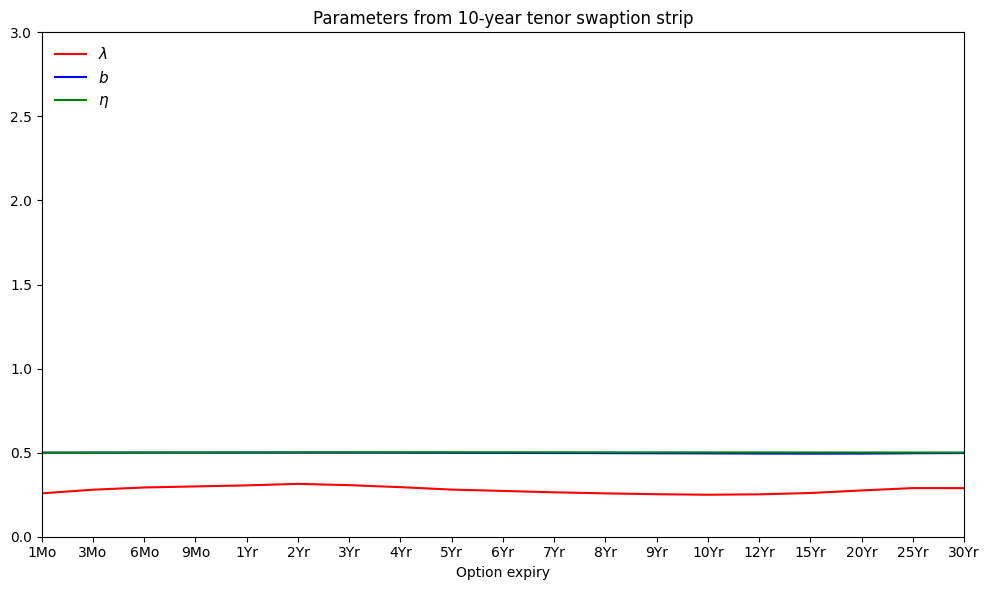

In [10]:
expiry = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])

# moneyness         +200  +100  +50  +25   ATM  -25   -50  -100  -200
weights = np.array([0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0])

lambd_calibrated = price_strips[0].copy()
b_calibrated = price_strips[0].copy()
eta_calibrated = price_strips[0].copy()
model_prices = price_strips[0].copy()
date = datetime.date(2023, 9, 18)

z_0 = 1
tenor = 10
theta = 0.6

M = len(expiry)

for m in range(M):  # calibrate swaption m
    T = expiry[m]
    print("Expiry = ", T)

    strikes_i = []
    swap_rate_i = []
    market_price_i = []

    for i in range(len(strike_strips)): # strikes loop

        strikes_i.append(strike_strips[i].iloc[m])
        swap_rate_i.append(swaprate_strips[i].iloc[m])
        market_price_i.append(price_strips[i].iloc[m])

    for p in range(1):  # calibrate (m,n)-swaption
        strikes = np.array(strikes_i)
        obs_prices = np.array(market_price_i)
        obs_swap_rates = np.array(swap_rate_i)

        bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf))

        init_lambd = 0.5
        init_b = 0.50
        init_eta = 0.50
        initguess = [init_lambd, init_b, init_eta]


        def Err(x):
            lambd, b, eta = x

            price_hat = []

            for i in range(len(strike_strips)):
                
                price_hat.append(payer_price_SV(obs_swap_rates[i], strikes[i], obs_swap_rates[i], theta, eta, lambd, b, z_0, date, T, tenor))

            price_hat = np.array(price_hat)
            err = np.sum(weights * (price_hat - obs_prices)**2)

            return err

    res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-14)
    lambd, b, eta = res.x

    lambd_calibrated[m] = lambd
    b_calibrated[m] = b
    eta_calibrated[m] = eta

    print('\n', "observed ATM price = ", market_price_i[4]) # market price
    print('\n', "calibrated ATM price = ", payer_price_SV(obs_swap_rates[4], strikes[4], obs_swap_rates[4], theta, eta, lambd, b, z_0, date, T, tenor))
    print('\n', 'calibrated lambda', lambd)
    print('\n', 'calibrated b', b)
    print('\n', 'calibrated eta', eta)

fig, ax = plt.subplots(figsize=(10,6))

ax.set_yticks(np.arange(0,3.5, 0.5))
ax.set_ylim(0,3)
ax.set_xlim(0, 18)
ax.set_xlabel('Option expiry')
ax.set_title('Parameters from 10-year tenor swaption strip')
plt.plot(lambd_calibrated.index, lambd_calibrated, label = '$\\lambda$', color = 'r')
plt.plot(b_calibrated.index, b_calibrated, label = '$b$', color = 'b')
plt.plot(eta_calibrated.index, eta_calibrated, label = '$\\eta$', color = 'g')
plt.legend(frameon=False, loc = 'upper left', fontsize=11)
fig.tight_layout()

plt.show()

In [ ]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

tenor = 10

points = ["3Mo", "1Yr", '5Yr', '10Yr', '15Yr', '25Yr']
theta = 0.6

mness = np.arange(0.4, 1.625, 0.025)
IV = np.empty((len(points), len(mness)))

for i in range(len(points)):
    lambd = lambd_calibrated[points[i]]
    eta = eta_calibrated[points[i]]
    b = b_calibrated[points[i]]

    print(lambd, eta, b)

    T = expiries[points[i]]
    print("T=",T)
    S = swaprate_strips[4][points[i]]
    strikes = mness * S

    for n in range(len(strikes)):

        K = strikes[n]
        
        print("model price",payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor))
    
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)

        res = fsolve(Root_Solving, 0.01)

        print("bach price", bachelier(S, K, res, date, T, tenor, tau_floating, t = 0))

        IV[i,n] = res * 10000   # convert to bp
        print(IV[i,n])

### IV plots

In [17]:
expiry = "3Mo"

three_month_iv = pd.Series([df_swaption_iv[0].loc[expiry, "10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[3].loc[expiry,"10Yr"], 
                         df_swaption_iv[4].loc[expiry,"10Yr"], df_swaption_iv[5].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"],
                         df_swaption_iv[8].loc[expiry,"10Yr"]], 
                         index = [df_strike[0].loc[expiry, "10Yr"] / (df_strike[0].loc[expiry, "10Yr"] - 0.02), df_strike[1].loc[expiry, "10Yr"] / (df_strike[1].loc[expiry, "10Yr"] - 0.01), 
                         df_strike[2].loc[expiry, "10Yr"] / (df_strike[2].loc[expiry, "10Yr"] - 0.005), df_strike[3].loc[expiry, "10Yr"]/ (df_strike[3].loc[expiry, "10Yr"] - 0.0025),
                         df_strike[4].loc[expiry, "10Yr"] / (df_strike[4].loc[expiry, "10Yr"]), df_strike[5].loc[expiry, "10Yr"] / (df_strike[5].loc[expiry, "10Yr"] + 0.0025), 
                         df_strike[6].loc[expiry, "10Yr"] / (df_strike[6].loc[expiry, "10Yr"] + 0.005), df_strike[7].loc[expiry, "10Yr"] / (df_strike[7].loc[expiry, "10Yr"] + 0.01),
                         df_strike[8].loc[expiry, "10Yr"] / (df_strike[8].loc[expiry, "10Yr"] + 0.02)])

expiry = "1Yr"

one_year_iv = pd.Series([df_swaption_iv[0].loc[expiry, "10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[3].loc[expiry,"10Yr"], 
                         df_swaption_iv[4].loc[expiry,"10Yr"], df_swaption_iv[5].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"],
                         df_swaption_iv[8].loc[expiry,"10Yr"]], 
                         index = [df_strike[0].loc[expiry, "10Yr"] / (df_strike[0].loc[expiry, "10Yr"] - 0.02), df_strike[1].loc[expiry, "10Yr"] / (df_strike[1].loc[expiry, "10Yr"] - 0.01), 
                         df_strike[2].loc[expiry, "10Yr"] / ( df_strike[2].loc[expiry, "10Yr"] - 0.005), df_strike[3].loc[expiry, "10Yr"]/ ( df_strike[3].loc[expiry, "10Yr"] - 0.0025),
                         df_strike[4].loc[expiry, "10Yr"] / (df_strike[4].loc[expiry, "10Yr"]), df_strike[5].loc[expiry, "10Yr"] / (df_strike[5].loc[expiry, "10Yr"] + 0.0025), 
                         df_strike[6].loc[expiry, "10Yr"] / (df_strike[6].loc[expiry, "10Yr"] + 0.005), df_strike[7].loc[expiry, "10Yr"] / (df_strike[7].loc[expiry, "10Yr"] + 0.01),
                         df_strike[8].loc[expiry, "10Yr"] / ( df_strike[8].loc[expiry, "10Yr"] + 0.02)])

expiry = "5Yr"

five_year_iv = pd.Series([df_swaption_iv[0].loc[expiry, "10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[3].loc[expiry,"10Yr"], 
                         df_swaption_iv[4].loc[expiry,"10Yr"], df_swaption_iv[5].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"],
                         df_swaption_iv[8].loc[expiry,"10Yr"]], 
                         index = [df_strike[0].loc[expiry, "10Yr"] / (df_strike[0].loc[expiry, "10Yr"] - 0.02), df_strike[1].loc[expiry, "10Yr"] / (df_strike[1].loc[expiry, "10Yr"] - 0.01), 
                         df_strike[2].loc[expiry, "10Yr"] / (df_strike[2].loc[expiry, "10Yr"] - 0.005), df_strike[3].loc[expiry, "10Yr"]/ ( df_strike[3].loc[expiry, "10Yr"] - 0.0025),
                         df_strike[4].loc[expiry, "10Yr"] / (df_strike[4].loc[expiry, "10Yr"]), df_strike[5].loc[expiry, "10Yr"] / (df_strike[5].loc[expiry, "10Yr"] + 0.0025), 
                         df_strike[6].loc[expiry, "10Yr"] / (df_strike[6].loc[expiry, "10Yr"] + 0.005), df_strike[7].loc[expiry, "10Yr"] / (df_strike[7].loc[expiry, "10Yr"] + 0.01),
                         df_strike[8].loc[expiry, "10Yr"] / (df_strike[8].loc[expiry, "10Yr"] + 0.02)])

expiry = "10Yr"

ten_year_iv = pd.Series([df_swaption_iv[0].loc[expiry, "10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[3].loc[expiry,"10Yr"], 
                         df_swaption_iv[4].loc[expiry,"10Yr"], df_swaption_iv[5].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"],
                         df_swaption_iv[8].loc[expiry,"10Yr"]], 
                         index = [df_strike[0].loc[expiry, "10Yr"] / (df_strike[0].loc[expiry, "10Yr"] - 0.02), df_strike[1].loc[expiry, "10Yr"] / (df_strike[1].loc[expiry, "10Yr"] - 0.01), 
                         df_strike[2].loc[expiry, "10Yr"] / (df_strike[2].loc[expiry, "10Yr"] - 0.005), df_strike[3].loc[expiry, "10Yr"]/ (df_strike[3].loc[expiry, "10Yr"] - 0.0025),
                         df_strike[4].loc[expiry, "10Yr"] / (df_strike[4].loc[expiry, "10Yr"]), df_strike[5].loc[expiry, "10Yr"] / (df_strike[5].loc[expiry, "10Yr"] + 0.0025), 
                         df_strike[6].loc[expiry, "10Yr"] / (df_strike[6].loc[expiry, "10Yr"] + 0.005), df_strike[7].loc[expiry, "10Yr"] / (df_strike[7].loc[expiry, "10Yr"] + 0.01),
                         df_strike[8].loc[expiry, "10Yr"] / (df_strike[8].loc[expiry, "10Yr"] + 0.02)])

expiry = "15Yr"

fifteen_year_iv = pd.Series([df_swaption_iv[0].loc[expiry, "10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[3].loc[expiry,"10Yr"], 
                         df_swaption_iv[4].loc[expiry,"10Yr"], df_swaption_iv[5].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"],
                         df_swaption_iv[8].loc[expiry,"10Yr"]], 
                         index = [df_strike[0].loc[expiry, "10Yr"] / (df_strike[0].loc[expiry, "10Yr"] - 0.02), df_strike[1].loc[expiry, "10Yr"] / (df_strike[1].loc[expiry, "10Yr"] - 0.01), 
                         df_strike[2].loc[expiry, "10Yr"] / (df_strike[2].loc[expiry, "10Yr"] - 0.005), df_strike[3].loc[expiry, "10Yr"]/ (df_strike[3].loc[expiry, "10Yr"] - 0.0025),
                         df_strike[4].loc[expiry, "10Yr"] / (df_strike[4].loc[expiry, "10Yr"]), df_strike[5].loc[expiry, "10Yr"] / (df_strike[5].loc[expiry, "10Yr"] + 0.0025), 
                         df_strike[6].loc[expiry, "10Yr"] / (df_strike[6].loc[expiry, "10Yr"] + 0.005), df_strike[7].loc[expiry, "10Yr"] / (df_strike[7].loc[expiry, "10Yr"] + 0.01),
                         df_strike[8].loc[expiry, "10Yr"] / (df_strike[8].loc[expiry, "10Yr"] + 0.02)])

expiry = "25Yr"

twentyfive_year_iv = pd.Series([df_swaption_iv[0].loc[expiry, "10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[3].loc[expiry,"10Yr"], 
                         df_swaption_iv[4].loc[expiry,"10Yr"], df_swaption_iv[5].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"],
                         df_swaption_iv[8].loc[expiry,"10Yr"]], 
                         index = [df_strike[0].loc[expiry, "10Yr"] / (df_strike[0].loc[expiry, "10Yr"] - 0.02), df_strike[1].loc[expiry, "10Yr"] / (df_strike[1].loc[expiry, "10Yr"] - 0.01), 
                         df_strike[2].loc[expiry, "10Yr"] / (df_strike[2].loc[expiry, "10Yr"] - 0.005), df_strike[3].loc[expiry, "10Yr"]/ (df_strike[3].loc[expiry, "10Yr"] - 0.0025),
                         df_strike[4].loc[expiry, "10Yr"] / (df_strike[4].loc[expiry, "10Yr"]), df_strike[5].loc[expiry, "10Yr"] / (df_strike[5].loc[expiry, "10Yr"] + 0.0025), 
                         df_strike[6].loc[expiry, "10Yr"] / (df_strike[6].loc[expiry, "10Yr"] + 0.005), df_strike[7].loc[expiry, "10Yr"] / (df_strike[7].loc[expiry, "10Yr"] + 0.01),
                         df_strike[8].loc[expiry, "10Yr"] / (df_strike[8].loc[expiry, "10Yr"] + 0.02)])

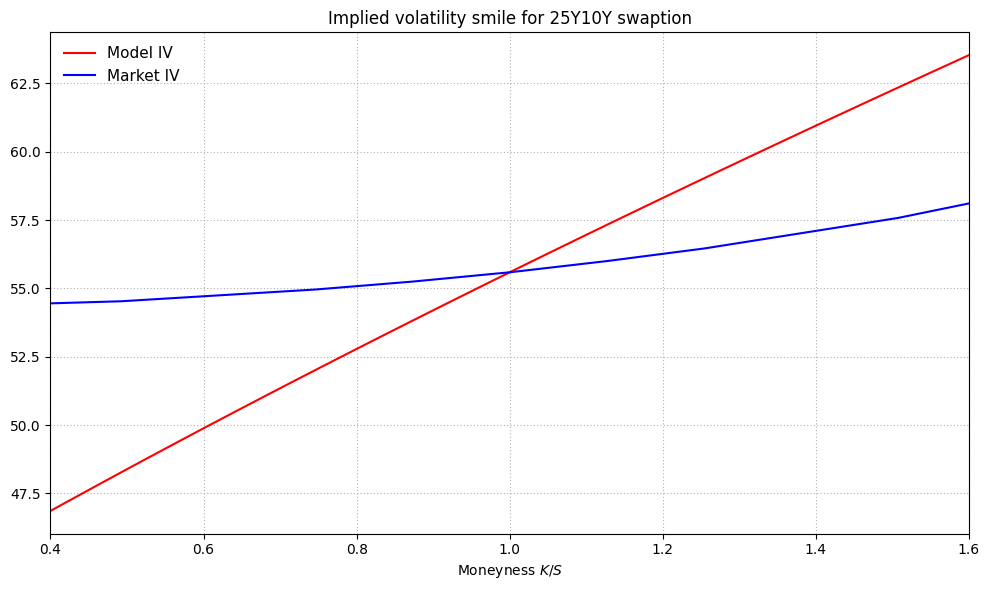

In [18]:
fig, ax = plt.subplots(figsize=(10,6))

# ax.set_yticks(np.arange(0,3.5, 0.5))
# ax.set_ylim(0,3)
ax.set_xlim(min(mness), max(mness))
ax.set_xlabel('Moneyness $K/S$')

# plt.plot(mness, IV[0], label = 'Model IV', color = 'r')
# plt.plot(three_month_iv.index, three_month_iv, label = 'Market IV', color = 'b')
# ax.set_title('Implied volatility smile for 3M10Y swaption')

# plt.plot(mness, IV[1], label = 'Model IV', color = 'r')
# plt.plot(one_year_iv.index, one_year_iv, label = 'Market IV', color = 'b')
# ax.set_title('Implied volatility smile for 1Y10Y swaption')

# plt.plot(mness, IV[2], label = 'Model IV', color = 'r')
# plt.plot(five_year_iv.index, five_year_iv, label = 'Market IV', color = 'b')
# ax.set_title('Implied volatility smile for 5Y10Y swaption')

# plt.plot(mness, IV[3], label = 'Model IV', color = 'r')
# plt.plot(ten_year_iv.index, ten_year_iv, label = 'Market IV', color = 'b')
# ax.set_title('Implied volatility smile for 10Y10Y swaption')

# plt.plot(mness, IV[4], label = 'Model IV', color = 'r')
# plt.plot(fifteen_year_iv.index, fifteen_year_iv, label = 'Market IV', color = 'b')
# ax.set_title('Implied volatility smile for 15Y10Y swaption')

plt.plot(mness, IV[5], label = 'Model IV', color = 'r')
plt.plot(twentyfive_year_iv.index, twentyfive_year_iv, label = 'Market IV', color = 'b')
ax.set_title('Implied volatility smile for 25Y10Y swaption')

plt.legend(frameon=False, loc = 'upper left', fontsize=11)
ax.grid(ls = (0,(1,2)))
fig.tight_layout()

plt.show()

## Calibration with weights

In [19]:
strike_strips = []
swaprate_strips = []
price_strips = []

for i in range(len(df_strike)):
    strike_strips.append(df_strike[i].loc[:,"10Yr"])
    swaprate_strips.append(df_swap_rate[i].loc[:,"10Yr"])
    price_strips.append(df_price[i].loc[:,"10Yr"])

Expiry =  0.08333333333333333

 observed ATM price =  0.008110799006955988

 calibrated ATM price =  0.008173766599407524

 calibrated lambda 0.2601718285261924

 calibrated b 0.0495118323296537

 calibrated eta 0.5646323899909288
Expiry =  0.25

 observed ATM price =  0.01502835328222943

 calibrated ATM price =  0.01501339839416021

 calibrated lambda 0.2935689013327284

 calibrated b 0.17371293535230958

 calibrated eta 2.3671945580253984
Expiry =  0.5

 observed ATM price =  0.02183857404856819

 calibrated ATM price =  0.021808301294163696

 calibrated lambda 0.3121288885358057

 calibrated b 0.18863526080403142

 calibrated eta 2.0776702476887254
Expiry =  0.75

 observed ATM price =  0.026809392297758933

 calibrated ATM price =  0.026770543110038982

 calibrated lambda 0.32168861843019114

 calibrated b 0.19541419571812343

 calibrated eta 1.9490289142209796
Expiry =  1.0

 observed ATM price =  0.031089967213253075

 calibrated ATM price =  0.031054962363178413

 calibrated la

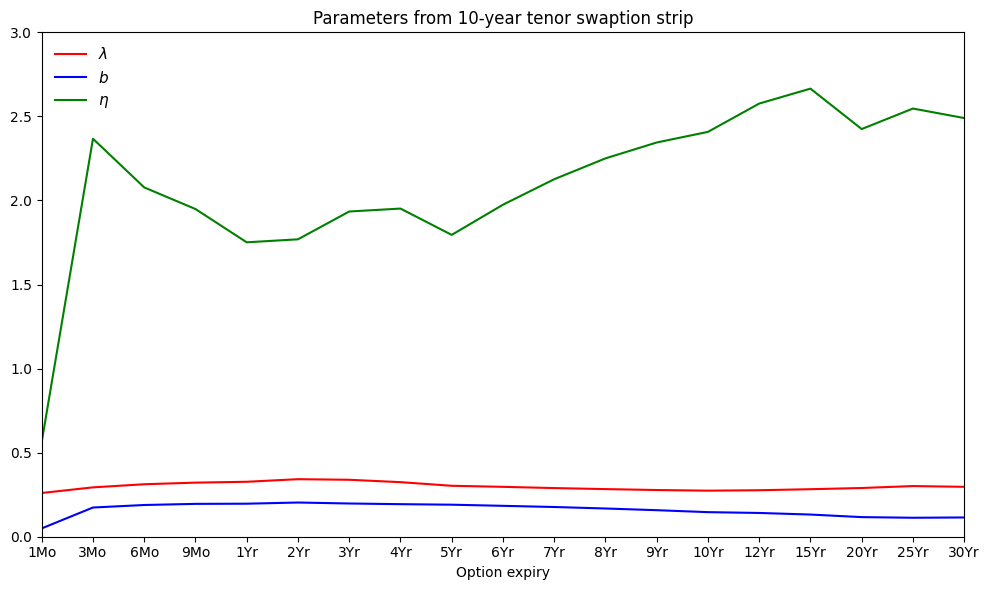

In [20]:
expiry = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])

# moneyness         +200  +100  +50  +25   ATM  -25   -50  -100  -200
weights = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

lambd_calibrated = price_strips[0].copy()
b_calibrated = price_strips[0].copy()
eta_calibrated = price_strips[0].copy()
model_prices = price_strips[0].copy()
date = datetime.date(2023, 9, 18)

z_0 = 1
tenor = 10
theta = 0.6

M = len(expiry)

for m in range(M):  # calibrate swaption m
    T = expiry[m]
    print("Expiry = ", T)

    strikes_i = []
    swap_rate_i = []
    market_price_i = []

    for i in range(len(strike_strips)): # strikes loop

        strikes_i.append(strike_strips[i].iloc[m])
        swap_rate_i.append(swaprate_strips[i].iloc[m])
        market_price_i.append(price_strips[i].iloc[m])

    for p in range(1):  # calibrate (m,n)-swaption
        strikes = np.array(strikes_i)
        obs_prices = np.array(market_price_i)
        obs_swap_rates = np.array(swap_rate_i)

        bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf))

        init_lambd = 0.5
        init_b = 0.50
        init_eta = 0.50
        initguess = [init_lambd, init_b, init_eta]


        def Err(x):
            lambd, b, eta = x

            price_hat = []

            for i in range(len(strike_strips)):
                
                price_hat.append(payer_price_SV(obs_swap_rates[i], strikes[i], obs_swap_rates[i], theta, eta, lambd, b, z_0, date, T, tenor))

            price_hat = np.array(price_hat)
            err = np.sum(weights * (price_hat - obs_prices)**2)

            return err

    res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-14)
    lambd, b, eta = res.x

    lambd_calibrated[m] = lambd
    b_calibrated[m] = b
    eta_calibrated[m] = eta

    print('\n', "observed ATM price = ", market_price_i[4]) # market price
    print('\n', "calibrated ATM price = ", payer_price_SV(obs_swap_rates[4], strikes[4], obs_swap_rates[4], theta, eta, lambd, b, z_0, date, T, tenor))
    print('\n', 'calibrated lambda', lambd)
    print('\n', 'calibrated b', b)
    print('\n', 'calibrated eta', eta)

fig, ax = plt.subplots(figsize=(10,6))

ax.set_yticks(np.arange(0,3.5, 0.5))
ax.set_ylim(0,3)
ax.set_xlim(0, 18)
ax.set_xlabel('Option expiry')
ax.set_title('Parameters from 10-year tenor swaption strip')
plt.plot(lambd_calibrated.index, lambd_calibrated, label = '$\\lambda$', color = 'r')
plt.plot(b_calibrated.index, b_calibrated, label = '$b$', color = 'b')
plt.plot(eta_calibrated.index, eta_calibrated, label = '$\\eta$', color = 'g')
plt.legend(frameon=False, loc = 'upper left', fontsize=11)
fig.tight_layout()

plt.show()

In [ ]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

tenor = 10

points = ["3Mo", "1Yr", '5Yr', '10Yr', '15Yr', '25Yr']
theta = 0.6

mness = np.arange(0.4, 1.625, 0.025)
IV = np.empty((len(points), len(mness)))

for i in range(len(points)):
    lambd = lambd_calibrated[points[i]]
    eta = eta_calibrated[points[i]]
    b = b_calibrated[points[i]]

    print(lambd, eta, b)

    T = expiries[points[i]]
    print("T=",T)
    S = swaprate_strips[4][points[i]]
    strikes = mness * S

    for n in range(len(strikes)):

        K = strikes[n]
        
        print("model price",payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor))
    
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)

        res = fsolve(Root_Solving, 0.01)
        print("K = ", K, "S = ", S,"IV = ", res)
        print("bach price", bachelier(S, K, res, date, T, tenor, tau_floating, t = 0))

        IV[i,n] = res * 10000   # convert to bp
        print(IV[i,n])

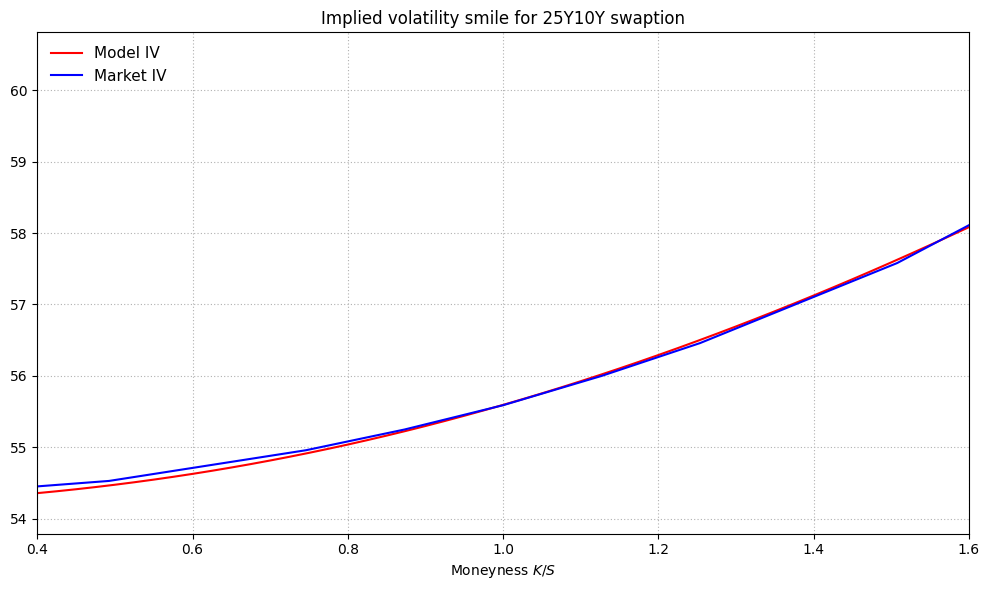

In [23]:
fig, ax = plt.subplots(figsize=(10,6))

# ax.set_yticks(np.arange(0,3.5, 0.5))
# ax.set_ylim(0,3)
ax.set_xlim(min(mness), max(mness))
ax.set_xlabel('Moneyness $K/S$')

# plt.plot(mness, IV[0], label = 'Model IV', color = 'r')
# plt.plot(three_month_iv.index, three_month_iv, label = 'Market IV', color = 'b')
# ax.set_title('Implied volatility smile for 3M10Y swaption')

# plt.plot(mness, IV[1], label = 'Model IV', color = 'r')
# plt.plot(one_year_iv.index, one_year_iv, label = 'Market IV', color = 'b')
# ax.set_title('Implied volatility smile for 1Y10Y swaption')

# plt.plot(mness, IV[2], label = 'Model IV', color = 'r')
# plt.plot(five_year_iv.index, five_year_iv, label = 'Market IV', color = 'b')
# ax.set_title('Implied volatility smile for 5Y10Y swaption')

# plt.plot(mness, IV[3], label = 'Model IV', color = 'r')
# plt.plot(ten_year_iv.index, ten_year_iv, label = 'Market IV', color = 'b')
# ax.set_title('Implied volatility smile for 10Y10Y swaption')

# plt.plot(mness, IV[4], label = 'Model IV', color = 'r')
# plt.plot(fifteen_year_iv.index, fifteen_year_iv, label = 'Market IV', color = 'b')
# ax.set_title('Implied volatility smile for 15Y10Y swaption')

plt.plot(mness, IV[5], label = 'Model IV', color = 'r')
plt.plot(twentyfive_year_iv.index, twentyfive_year_iv, label = 'Market IV', color = 'b')
ax.set_title('Implied volatility smile for 25Y10Y swaption')

plt.legend(frameon=False, loc = 'upper left', fontsize=11)
ax.grid(ls = (0,(1,2)))
fig.tight_layout()

plt.show()

# Pricing a 5nc1

### Calibration

In [24]:
strike_strips = []
swaprate_strips = []
price_strips = []

expir = 1
ten = 4

for i in range(3):

    strike_strips.append(df_strike[4].loc[str(expir)+"Yr",str(ten)+"Yr"])
    swaprate_strips.append(df_swap_rate[4].loc[str(expir)+"Yr",str(ten)+"Yr"])
    price_strips.append(df_price[4].loc[str(expir)+"Yr",str(ten)+"Yr"])

    expir += 1
    ten -= 1
    
strike_strips.append(df_strike[4].loc[str(expir)+"Yr",str(ten)+"Yr"])
swaprate_strips.append(df_swap_rate[4].loc[str(expir)+"Yr",str(ten)+"Yr"])
price_strips.append(df_price[4].loc[str(expir)+"Yr",str(ten)+"Yr"])

strike_strips = np.array(strike_strips)
swaprate_strips = np.array(swaprate_strips)
price_strips = np.array(price_strips)

In [ ]:
expiry = np.array([1,2,3,4])
tenors = np.array([4,3,2,1])

lambd_calibrated = np.zeros_like(strike_strips)
b_calibrated = np.zeros_like(strike_strips)
eta_calibrated = np.zeros_like(strike_strips)
model_prices = np.zeros_like(strike_strips)

z_0 = 1
theta = 0.6

M = len(expiry)

for m in range(M):  # calibrate (m,n) swaption
    T = expiry[m]
    tenor = tenors[m]

    print("Expiry = ", T, "Tenor = ", tenor)

    bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf))

    init_lambd = 0.50
    init_b = 0.50
    init_eta = 0.50
    initguess = [init_lambd, init_b, init_eta]

    def Err(x):
        lambd, b, eta = x

        model_price = payer_price_SV(swaprate_strips[m], strike_strips[m], swaprate_strips[m], theta, eta, lambd, b, z_0, date, T, tenor)

        err = (model_price - price_strips[m])**2

        return err

    res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-14)
    lambd, b, eta = res.x

    lambd_calibrated[m] = lambd
    b_calibrated[m] = b
    eta_calibrated[m] = eta

    print('\n', "observed ATM price = ", price_strips[m]) # market price
    print('\n', "calibrated ATM price = ", payer_price_SV(swaprate_strips[m], strike_strips[m], swaprate_strips[m], theta, eta, lambd, b, z_0, date, T, tenor))
    print('\n', 'calibrated lambda', lambd)
    print('\n', 'calibrated b', b)
    print('\n', 'calibrated eta', eta)

In [26]:
def create_cubic_curve_cc(t, T, tau, date, curve_data): # returns cubic spline interpolated curve in cont. comp. rates
    ts = pd.Series(np.arange(t, T+tau, tau))
    curve = ts.copy()

    for i in range(len(ts)):
        tt = ts.iloc[i]
        curve.iloc[i] = np.log(1 + cubspline_curve(date, tt, curve_data))

    samlet = pd.DataFrame(curve, columns =['Rate']).set_index(ts.values)
    samlet.index.name = 'T'

    return samlet

date = datetime.date(2023,9,18)
cubic_swap_curve = create_cubic_curve_cc(0, 30, 0.25, date, EUSA)

def trap_integration(xmin, xmax, N):
    # Computes integration points and weights for trapezoid scheme
    # integrates from xmin to xmax with N integration points
    uv = np.linspace(xmin, xmax, N)
    wgtv = np.ones(N)
    wgtv[[0, N - 1]] = 1 / 2
    wgtv = wgtv * (xmax - xmin) / (N - 1)
    return uv, wgtv

def bond_func(cubic_curve, t, T, x, y, kappa):

    P_0_T = np.exp(-cubic_curve.loc[T].values.T * T)                        # convert rate_T to P(0,T)
    P_0_t = np.exp(-cubic_curve.loc[t].values.T * t)                        # convert rate_t to P(0,t)
    G_t_T = (1 - np.exp(-kappa * (T - t))) / kappa                          # assume kappa(t)=kappa (constant kappa over each period)

    return P_0_T / P_0_t * np.exp(-G_t_T * x - 1/2 * G_t_T**2 * y)

def partial_S_x(t, x, y, S, kappa, expiry, tenor, cubic_curve):
    G_t_T0 = (1 - np.exp(-kappa * (expiry - t))) / kappa
    G_t_TN = (1 - np.exp(-kappa * (expiry + tenor - t))) / kappa 
    P_t_T0 = bond_func(cubic_curve, t, expiry, x, y, kappa)
    P_t_TN = bond_func(cubic_curve, t, expiry + tenor, x, y, kappa)

    ann = 0
    sum = 0
    for i in range(tenor):
        ann += bond_func(cubic_curve, t, expiry + i + 1, x, y, kappa)
        sum += ((1 - np.exp(-kappa * (expiry + i + 1 - t))) / kappa) * bond_func(cubic_curve, t, expiry + i + 1, x, y, kappa)

    # S_t = (P_t_T0 - P_t_TN) / ann

    return -(G_t_T0 * P_t_T0 - G_t_TN * P_t_TN) / ann + S / ann * sum

## Simulating the state variables

t =  0 lambda =  0.32825261270789424 b =  0.49998123866613303 eta =  0.5015428853320959
t =  1 lambda =  0.3545558108524272 b =  0.5002123935879729 eta =  0.5019074682701751
t =  2 lambda =  0.35804013182791206 b =  0.5003529874393926 eta =  0.501966679222617
t =  3 lambda =  0.3499979583141596 b =  0.5002241036535043 eta =  0.501881110307217
t =  4 lambda =  0.3499979583141596 b =  0.5002241036535043 eta =  0.501881110307217


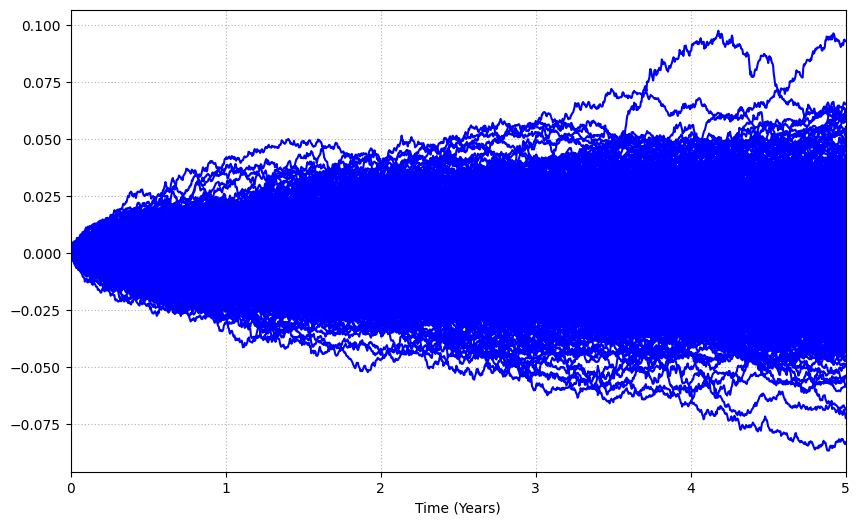

In [34]:
def model_sim(kappa, theta, dt, paths, lambds, etas, bs, swaprate_strip, cubic_curve):

    sim_horizon = len(lambds)+1

    steps = sim_horizon * 252
    numb_sims = steps + 1

    size = (numb_sims, paths)
    x = np.zeros(size)
    y = np.zeros(size)
    z = np.zeros(size)

    mean = np.array([0,0])
    cov = np.array([[1,0],
                    [0,1]])

    z_0 = 1
    x_t = 0
    y_t = 0

    z_t = z_0
    Z_t = z_0

    x[0,:] = x_t
    y[0,:] = y_t
    z[0,:] = z_t

    zeros = np.zeros(len(x.T))

    lambds = np.append(lambds, lambds[-1])
    etas = np.append(etas, etas[-1])
    bs = np.append(bs, bs[-1])
    swaprate_strip = np.append(swaprate_strip, swaprate_strip[-1])

    for i in range(sim_horizon):

        lambd = lambds[i]
        b = bs[i]
        eta = etas[i]
        S_0 = swaprate_strip[i]

        sigma_r = lambd * (S_0 + b * partial_S_x(i+1,0,0, S_0, kappa, i+1, sim_horizon-i, cubic_curve) * x[i,:])

        print("t = ", i, "lambda = ", lambd, "b = ", b, "eta = ", eta)

        for t in range(252):

            W_t = np.transpose(np.random.multivariate_normal(mean, cov, size = paths) * np.sqrt(dt))

            x_t = x_t + (y_t - kappa * x_t) * dt + np.sqrt(Z_t) * sigma_r * W_t[0,:]
            y_t = y_t + (Z_t * sigma_r**2 - 2 * kappa * y_t) * dt
            z_t = z_t + theta * (z_0 - Z_t) * dt + eta * np.sqrt(Z_t) * W_t[1,:]

            Z_t = np.maximum(zeros, z_t)

            x[1 + i*252 + t,:] = x_t
            y[1 + i*252 + t,:] = y_t
            z[1 + i*252 + t,:] = z_t
    return x, y, z

theta = 0.6
kappa = 0.05

dt = 1/252
paths = 1000

date = datetime.date(2023,9,18)
cubic_swap_curve = create_cubic_curve_cc(0, 30, 0.25, date, EUSA)

sim = model_sim(kappa, theta, dt, paths, lambd_calibrated, eta_calibrated, b_calibrated, swaprate_strips, cubic_swap_curve)

x_sim = pd.DataFrame(sim[0]).set_index(np.arange(0, 5+dt, dt))
y_sim = pd.DataFrame(sim[1]).set_index(np.arange(0, 5+dt, dt))
z_sim = pd.DataFrame(sim[2]).set_index(np.arange(0, 5+dt, dt))

fig, ax = plt.subplots(figsize=(10,6))

ax.set_xlim(0, 5)
ax.grid(ls = (0,(1,2)))
ax.set_xlabel('Time (Years)')
plt.plot(x_sim.index, x_sim, color='b')
# plt.plot(y_sim.index, y_sim, color='r')
# plt.plot(z_sim.index, z_sim, color='g')
plt.show()

## Pricing a 5nc1 Bermudan

In [36]:
# define basis functions
constFunc = lambda *args, **kwargs: np.ones_like(kwargs['xt'])
xt = lambda xt, *args, **kwargs: xt
yt = lambda yt, *args, **kwargs: yt
zt = lambda zt, *args, **kwargs: zt

set1 = [constFunc, xt, yt, zt]

In [54]:
def bermudan_price(K, kappa, theta, dt, paths, lambds, etas, bs, swaprate_strip, cubic_curve):

    np.random.seed(1234)

    sim_horizon = len(lambds)+1 

    steps = sim_horizon * 252
    numb_sims = steps + 1

    size = (numb_sims, paths)
    x = np.zeros(size)
    y = np.zeros(size)
    z = np.zeros(size)

    mean = np.array([0,0])
    cov = np.array([[1,0],
                    [0,1]])

    z_0 = 1
    x_t = 0
    y_t = 0

    z_t = z_0
    Z_t = z_0

    x[0,:] = x_t
    y[0,:] = y_t
    z[0,:] = z_t

    zeros = np.zeros(len(x.T))

    lambds = np.append(lambds, lambds[-1])
    etas = np.append(etas, etas[-1])
    bs = np.append(bs, bs[-1])
    swaprate_strip = np.append(swaprate_strip, swaprate_strip[-1])

    for i in range(sim_horizon):

        lambd = lambds[i]
        b = bs[i]
        eta = etas[i]
        S_0 = swaprate_strip[i]

        # sigma_r = lambd * (S_0 + b * partial_S_x(i+1,0,0, S_0, kappa, i+1, sim_horizon-i, cubic_curve) * x[i,:])
        sigma_r = 0.03

        for t in range(252):

            W_t = np.transpose(np.random.multivariate_normal(mean, cov, size = paths) * np.sqrt(dt))

            x_t = x_t + (y_t - kappa * x_t) * dt + np.sqrt(Z_t) * sigma_r * W_t[0,:]
            y_t = y_t + (Z_t * sigma_r**2 - 2 * kappa * y_t) * dt
            z_t = z_t + theta * (z_0 - Z_t) * dt + eta * np.sqrt(Z_t) * W_t[1,:]

            Z_t = np.maximum(zeros, z_t)

            x[1 + i*252 + t,:] = x_t
            y[1 + i*252 + t,:] = y_t
            z[1 + i*252 + t,:] = z_t

    year_frac = np.round(np.linspace(dt, sim_horizon, sim_horizon * int(1/dt)),12)
    year_frac = np.append(0,year_frac)

    exercise_dates = np.arange(1,sim_horizon,1)
    df_x = pd.DataFrame(x).set_index(year_frac)
    df_y = pd.DataFrame(y).set_index(year_frac)
    df_z = pd.DataFrame(z).set_index(year_frac)

    x_exercise = np.where(df_x.index.isin(exercise_dates))
    y_exercise = np.where(df_y.index.isin(exercise_dates))
    z_exercise = np.where(df_z.index.isin(exercise_dates))

    df_x = np.array(df_x)
    df_y = np.array(df_y)
    df_z = np.array(df_z)

    x_berm = df_x[x_exercise]
    y_berm = df_y[y_exercise]
    z_berm = df_z[z_exercise]

    swap_rates = np.zeros(x_berm.shape)

    swap_rates = []
    annuities = []
    annuities_misc = []

    # calculate swap rates
    for i in range(sim_horizon-1):

        tenor = len(x_berm[i:])
        ann_len = sim_horizon - 1 - len(x_berm[i:])
        annuity = 0
        
        # annuities for swap rate
        for n in range(sim_horizon - 1, ann_len,-1):
            
            if n == ann_len + 1:
                P_t_Tn = bond_func(cubic_swap_curve, n, sim_horizon, x_berm[n-1], y_berm[n-1], kappa)
                annuity += P_t_Tn

            if n != ann_len + 1:
                annuity += bond_func(cubic_swap_curve, n, sim_horizon, x_berm[n-1], y_berm[n-1], kappa)
        
        swap_rate = (1 - P_t_Tn) / annuity
        swap_rates.append(swap_rate)
        annuities.append(annuity)

        # annuities for discounting
        annuity_disc = bond_func(cubic_swap_curve, i+1, i+2, x_berm[i], y_berm[i], kappa)    # period = 1, so the annuity is just a single discount factor
        annuities_misc.append(annuity_disc)

    swap_rates_berm = np.array(swap_rates)

    annuities_berm = np.array(annuities)
    annuities_berm_disc = np.array(annuities_misc)      # annuities for single-period discounting

    payer_payoff = annuities_berm * np.maximum(swap_rates_berm - K, 0) 

    swaption_val = np.zeros_like(payer_payoff)          # matrix for option values
    swaption_val[-1,:] = payer_payoff[-1,:]             # payoff in final row

    # european benchmark
    european = swaption_val[-1,:]

    # LSM algorithm
    for t in range(sim_horizon - 3, -1, -1):  # backwards loop from end (total number of loops = sim_horizon - 2 since we have value at sim_horizon - 1 from payoff)

        ITM = payer_payoff[t,:].nonzero()       # paths that are ITM at time t
        OTM = np.where(payer_payoff[t,:] == 0)  # paths that are OTM at time t

        df = annuities_berm_disc[t+1,:]         # discount factor A_(t_i-1,t_i)

        european = european * df                # european is never exercised (i.e., just discounted period-wise)

        swaption_val[t,:][OTM] = swaption_val[t+1,:][OTM] * df[OTM]  # Option value at time t, if swaption is OTM   # if OTM we will hold (exercise value = 0)

        Y = swaption_val[t+1,:][ITM] * df[ITM]  # discounted realized cash flow from continuation at time t+1

        # X inputs in basis fuctions
        St = swap_rates_berm[t,:][ITM]      
        xt = x_berm[t,:][ITM]
        yt = x_berm[t,:][ITM]
        zt = z_berm[t,:][ITM] 

        X = np.array(list(map(lambda func: func(St=St, K=K, xt=xt, yt=yt, zt=zt), set1))).T    # map values into the basis functions

        # cross-sectional regression
        reg = sm.OLS(Y, X).fit()

        # evaluate regression at each loop (Continuation value)
        ContValue = reg.fittedvalues  

        swaption_val[t,:][ITM] = np.where(payer_payoff[t,:][ITM] > ContValue,  # is immediate exercise > than continuation?
                                        payer_payoff[t,:][ITM], swaption_val[t+1,:][ITM] * df[ITM])  # True = exercise, False = discounted continuation value


    bermudan_t_0 = np.mean(swaption_val[0,:] * annuities_berm_disc[0,:])
    european_t_0 = np.mean(european * annuities_berm_disc[0,:])    

    return bermudan_t_0, european_t_0

dt = 1/252
paths = 1000
K = 0.0296

kappa = 1.08
theta = 0.6

date = datetime.date(2023,9,18)
cubic_swap_curve = create_cubic_curve_cc(0, 30, 0.25, date, EUSA)

bermudan = bermudan_price(K, kappa, theta, dt, paths, lambd_calibrated, eta_calibrated, b_calibrated, swaprate_strips, cubic_swap_curve)[0]
european = bermudan_price(K, kappa, theta, dt, paths, lambd_calibrated, eta_calibrated, b_calibrated, swaprate_strips, cubic_swap_curve)[1]

print("Bermudan = ", bermudan)
print("European 4Y1Y = ", european)

Bermudan =  0.013619510574239385
European 4Y1Y =  0.004565301715902471


### European core swaptions

In [65]:
# europæiske priser
lambd = 0.25
eta = 1.9
b = 0.18
K = 0.03
z_0 = 1
date = datetime.date(2023, 9, 18)

expiry = 1
tenor = 4
S = 0.0312
K = 0.035
price_1 = payer_price_SV(S, K , S, theta, eta, lambd, b, z_0, date, expiry, tenor)

expiry = 2
tenor = 3
S = 0.0299
K = S
price_2 = payer_price_SV(S, K , S, theta, eta, lambd, b, z_0, date, expiry, tenor)

expiry = 3
tenor = 2
S = 0.0296
K = S
price_3 = payer_price_SV(S, K , S, theta, eta, lambd, b, z_0, date, expiry, tenor)

expiry = 4
tenor = 1
S = 0.0296
K = S
price_4 = payer_price_SV(S, K , S, theta, eta, lambd, b, z_0, date, expiry, tenor)
print("European 1Y4Y = ", price_1)
print("European 2Y3Y = ", price_2)
print("European 3Y2Y = ", price_3)
print("European 4Y1Y = ", price_4)

European 1Y4Y =  0.005150683471282155
European 2Y3Y =  0.010001689802872174
European 3Y2Y =  0.007955764723443894
European 4Y1Y =  0.00454536459932549


### Core correlations

In [63]:
def create_cubic_curve_cc(t, T, ts, date, curve_data): # returns cubic spline interpolated curve in cont. comp. rates
    ts = pd.Series(ts)
    curve = ts.copy()

    for i in range(len(ts)):
        tt = ts.iloc[i]
        curve.iloc[i] = np.log(1 + cubspline_curve(date, tt, curve_data))

    samlet = pd.DataFrame(curve, columns =['Rate']).set_index(ts.values)
    samlet.index.name = 'T'

    return samlet

date = datetime.date(2023,9,18)
cubic_swap_curve = create_cubic_curve_cc(0, 30, 0.25, date, EUSA)

def correlation_func(S1, S2, T1, T2, tenor1, tenor2, kappa):
    xmin = 0
    xmax_1 = T1
    xmax_2 = T2
    int_points = 100+1
    [t_points_1, wgt_1] = trap_integration(xmin, xmax_1, xmax_1 * (int_points - 1) + 1)
    [t_points_2, wgt_2] = trap_integration(xmin, xmax_2, xmax_2 * (int_points - 1) + 1)
    
    curve_points = np.linspace(0,30,30*(int_points - 1) + 1)
    cubic_swap_curve = create_cubic_curve_cc(0, 30, curve_points, date, EUSA)

    integrand_1 = partial_S_x(t_points_1, 0, 0, S1, kappa, T1, tenor1, cubic_swap_curve) * partial_S_x(t_points_1, 0, 0, S2, kappa, T2, tenor2, cubic_swap_curve)

    # print("1", partial_S_x(t_points_1, 0, 0, S1, kappa, T1, tenor1, cubic_swap_curve))
    # print("2", partial_S_x(t_points_1, 0, 0, S2, kappa, T2, tenor2, cubic_swap_curve))

    integral_1 = np.sum(integrand_1 * wgt_1)

    integrand_2 = partial_S_x(t_points_1, 0, 0, S1, kappa, T1, tenor1, cubic_swap_curve)**2
    integral_2 = np.sum(integrand_2 * wgt_1)

    integrand_3 = partial_S_x(t_points_2, 0, 0, S2, kappa, T2, tenor2, cubic_swap_curve)**2
    integral_3 = np.sum(integrand_3 * wgt_2)

    print(integral_1)
    print((integral_2)**(-1/2))
    print((integral_3)**(-1/2))

    return integral_1 * (integral_2)**(-1/2) * (integral_3)**(-1/2)

In [70]:
date = datetime.date(2023,9,18)
cubic_swap_curve = create_cubic_curve_cc(0, 30, 0.25, date, EUSA)

kappa = 0.05

# correlation between 1y4y and 2y3y
S1 = 0.0299
T1 = 1
tenor1 = 4

S2 = 0.0296
T2 = 2
tenor2 = 3

# bnds = ((0.01, None))
# init_kappa = 0.05
# initguess = [init_kappa]

# def Err(x):
#     kappa = x
#     err = (0.40 - correlation_func(S1, S2, T1, T2, tenor1, tenor2, kappa))**2
#     return err

# res = opt.minimize(Err, initguess, tol = 1e-3)
# kappa = res.x

correlation_func(S1, S2, T1, T2, tenor1, tenor2, kappa)

0.8138531625574322
1.0921746366983482
0.7753863954830417


0.689217536428855